# These are the Cartography visuals.

# To Do:
- make HA only and HA + NA sections, get snakemake notebook_docs folder ready

# Imports Section 

In [68]:
import sys
sys.path.append("../notebooks/scripts/")

In [69]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [3]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [4]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [5]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [6]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [7]:
clades_to_plot = ['3c2', '3c2.A', '3c3.A', 'A1','A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A1b/137F', 'A1b/186D', 'A1b/197R', 'A1b/94N', 'A2', 'A2/re', 'A3']
domain =   ['3c', '3c2', '3c2.A', '3c3', '3c3.A', 'A1', 'A1a', 'A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A1b/137F', 'A1b/186D', 'A1b/197R', 'A1b/94N', 'A2', 'A2/re', 'A3', 'A4']
range_ = ['#4e38d5', '#6626d4', '#4138c3', '#4c89e8', '#4e70ff', '#5499ff', '#79c9a1', '#61b8f0', '#5499ff', '#87dfb3','#a0e994', '#bdee78', '#ddee64', '#f8e957', '#ffdb4e', '#ffc348', '#ff9e40', '#ff6e36', '#f93529']


# Reading in all the data from the scripts

In [8]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/ha-na-nextstrain'

In [9]:
#node_df = pd.read_csv(node_df, sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [10]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [11]:
node_df.head()

,strain,date,pca1,pca2,pca3,pca4,mds1,mds2,tsne_x,tsne_y,umap_x,umap_y,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y
0,A/RobatKarim/21210/2016,2016.05,4.12,0.42,-0.28,-0.21,12.24,-15.05,37.30,-3.63,7.37,13.42,3c3,-1,-1,0,6,1
1,A/MUWRP-Uganda/579/2016,2016.67,4.91,1.18,-0.48,0.10,38.87,-6.67,38.91,0.74,-14.95,6.82,3c3,-1,0,7,6,2
2,A/Sydney/29/2016,2016.03,6.52,1.08,-0.50,0.36,11.03,-33.96,36.61,-4.23,-14.96,5.92,3c3,-1,0,7,6,3
3,A/Arkansas/02/2016,2016.08,6.52,1.09,-0.50,0.36,11.10,-33.95,36.66,-4.19,-14.89,6.08,3c3,-1,0,7,6,4
4,A/Pennsylvania/08/2016,2016.02,6.55,1.09,-0.51,0.37,31.34,-17.31,36.67,-4.20,-14.89,5.85,3c3,-1,0,7,6,5


In [12]:
all_clades = node_df["clade_membership"].drop_duplicates().values

In [13]:
all_clades

array(['3c3', '3c3.A', '3c2', 'A4', 'A3', '3c2.A', 'A2', 'A2/re', 'A1',
       'A1a', 'A1b', 'A1b/135K', 'A1b/135N'], dtype=object)

In [14]:
set(domain)

{'3c',
 '3c2',
 '3c2.A',
 '3c3',
 '3c3.A',
 'A1',
 'A1a',
 'A1b',
 'A1b/131K',
 'A1b/135K',
 'A1b/135N',
 'A1b/137F',
 'A1b/186D',
 'A1b/197R',
 'A1b/94N',
 'A2',
 'A2/re',
 'A3',
 'A4'}

In [15]:
set(all_clades) - set(domain)

set()

In [16]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [17]:
node_df.head()

,strain,date,pca1,pca2,pca3,pca4,mds1,mds2,tsne_x,tsne_y,umap_x,umap_y,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y,clade_membership_color
0,A/RobatKarim/21210/2016,2016.05,4.12,0.42,-0.28,-0.21,12.24,-15.05,37.30,-3.63,7.37,13.42,3c3,-1,-1,0,6,1,other
1,A/MUWRP-Uganda/579/2016,2016.67,4.91,1.18,-0.48,0.10,38.87,-6.67,38.91,0.74,-14.95,6.82,3c3,-1,0,7,6,2,other
2,A/Sydney/29/2016,2016.03,6.52,1.08,-0.50,0.36,11.03,-33.96,36.61,-4.23,-14.96,5.92,3c3,-1,0,7,6,3,other
3,A/Arkansas/02/2016,2016.08,6.52,1.09,-0.50,0.36,11.10,-33.95,36.66,-4.19,-14.89,6.08,3c3,-1,0,7,6,4,other
4,A/Pennsylvania/08/2016,2016.02,6.55,1.09,-0.51,0.37,31.34,-17.31,36.67,-4.20,-14.89,5.85,3c3,-1,0,7,6,5,other


# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [18]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf_ha = pd.read_csv("results/embed_pca_ha.csv", index_col=0)
principalDf_concatenated = pd.read_csv("results/embed_pca_concatenated.csv", index_col=0)

In [19]:
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df_ha = pd.read_csv("results/explained_variance_pca_ha.csv")
explained_variance_df_concatenated = pd.read_csv("results/explained_variance_pca_concatenated.csv")

In [20]:
explained_variance_df_ha

,explained variance,principal components
0,0.2652,1
1,0.2039,2
2,0.0826,3
3,0.0528,4
4,0.0334,5
5,0.0262,6
6,0.0209,7
7,0.0146,8
8,0.0116,9
9,0.0113,10


In [21]:
explained_variance_df_concatenated

,explained variance,principal components
0,0.4096,1
1,0.1378,2
2,0.0823,3
3,0.0458,4
4,0.0314,5
5,0.0194,6
6,0.0163,7
7,0.0129,8
8,0.0120,9
9,0.0106,10


Text(0.5, 1.0, 'Explained Variance Plot (Flu, HA-only)')

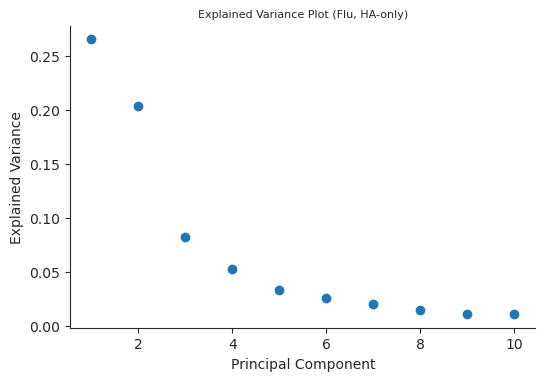

In [22]:
plt.plot(explained_variance_df_ha['principal components'].values.tolist(), explained_variance_df_ha["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Flu, HA-only)")

#plt.savefig(snakemake.output.Explained_variance_PCA)

Text(0.5, 1.0, 'Explained Variance Plot (Flu, HA and NA)')

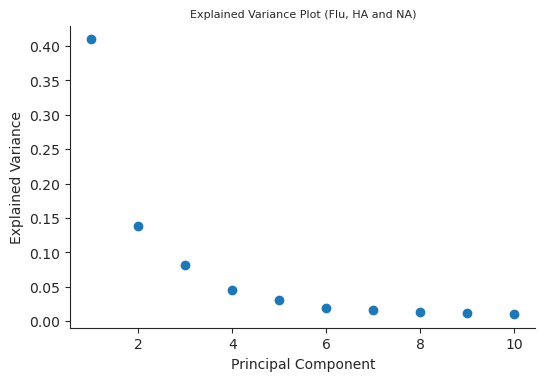

In [23]:
plt.plot(
    explained_variance_df_concatenated['principal components'].values.tolist(),
    explained_variance_df_concatenated["explained variance"].values.tolist(),
    'o'
)

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Flu, HA and NA)")

#plt.savefig(snakemake.output.Explained_variance_PCA)

In [24]:
merged_pca_df_ha = principalDf_ha.merge(node_df[["strain", "date", "y", "clade_membership"]], on="strain")
merged_pca_df_concatenated = principalDf_concatenated.merge(node_df[["strain", "date", "y", "clade_membership"]], on="strain")

In [25]:
explained_variance_PCA_ha = explained_variance_df_ha["explained variance"].values.tolist()
explained_variance_PCA_concatenated = explained_variance_df_concatenated["explained variance"].values.tolist()

### Bases Missing Analysis for PCA 

In [31]:
from Bio import SeqIO
strains = []
genomes = []
for record in SeqIO.parse("results/aligned_concatenated.fasta", "fasta"):
    strains.append(str(record.id))
    genomes.append(str(record.seq))

#Checking missing_bases

genomes_missing_bases = []
for x in genomes:
    x = re.sub(r'[^AGCT]', '5', x)
    numberOfN = x.count("5") #This logic is here because MERS uses both "N" and "-" to dileneate missing sequences.
    genomes_missing_bases.append(numberOfN)
    
bases_df = pd.DataFrame([strains, genomes_missing_bases]).transpose()
bases_df.columns = ["strain", "bases_missing"]

In [46]:
strains = []
genomes = []
for record in SeqIO.parse("results/aligned_ha.fasta", "fasta"):
    strains.append(str(record.id))
    genomes.append(str(record.seq))

#Checking missing_bases

genomes_missing_bases = []
for x in genomes:
    x = re.sub(r'[^AGCT]', '5', x)
    numberOfN = x.count("5") #This logic is here because MERS uses both "N" and "-" to dileneate missing sequences.
    genomes_missing_bases.append(numberOfN)
    
bases_df_ha = pd.DataFrame([strains, genomes_missing_bases]).transpose()
bases_df_ha.columns = ["strain", "bases_missing"]
merged_total_ha = bases_df.merge(merged_pca_df_ha, on="strain")

In [33]:
merged_total = bases_df.merge(merged_pca_df_concatenated, on="strain")
merged_total

,strain,bases_missing,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca_label,date,y,clade_membership
0,A/Louisiana/15/2017,445,-2.783376,1.130833,-0.447528,0.598199,-1.826996,-1.949919,1.566074,-0.405781,3.387020,2.595280,3,2017.20,221,A4
1,A/Texas/274/2017,433,-2.737475,-0.433640,-0.582424,0.819035,-1.564810,-1.900533,1.374408,-0.634744,3.521770,2.243740,3,2017.41,220,A4
2,A/Brisbane/18/2017,457,11.183939,-0.153380,-1.033682,0.460889,-1.159202,-1.813330,1.264603,-0.370894,3.190409,2.274640,4,2017.06,217,A4
3,A/Townsville/2/2017,457,11.186746,-0.154454,-1.038000,0.491568,-1.129172,-1.799711,1.245935,-0.371827,3.179656,2.279281,4,2017.14,218,A4
4,A/Sydney/38/2017,434,-2.656680,-0.443814,-0.576143,0.839215,-1.569651,-1.868359,1.353184,-0.606289,3.520541,2.272199,3,2017.12,222,A4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,A/Georgia/68828/2018,457,10.872783,7.928028,-0.032861,0.732435,1.432581,1.739985,4.359334,0.741754,-0.422117,0.382889,-1,2018.02,8,3c3.A
1639,A/Louisiana/17/2017,430,-3.036133,7.583629,0.401851,1.148255,1.044225,1.638242,4.871020,0.470321,0.212126,0.613750,0,2017.17,7,3c3.A
1640,A/Texas/305/2017,434,-2.473128,7.668320,0.395724,1.087651,1.059018,1.641439,4.503755,0.500603,-0.128185,0.373675,0,2017.91,9,3c3.A
1641,A/RobatKarim/21210/2016,457,10.922180,5.343266,-0.343392,-0.566782,0.431605,0.175764,0.930796,0.209909,-0.093044,-0.121568,2,2016.05,1,3c3


In [35]:
list_of_chart_ha = linking_tree_with_plots_brush(merged_pca_df_ha,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)

list_of_chart_concatenated = linking_tree_with_plots_brush(merged_total,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership", "bases_missing"], domain, range_)
PCAFluBrush_ha = list_of_chart_ha[0]|list_of_chart_ha[1]|list_of_chart_ha[2]
PCAFluBrush_concatenated = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]|list_of_chart_concatenated[2]

alt.vconcat(PCAFluBrush_ha,PCAFluBrush_concatenated)
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.VConcatChart(...)

In [48]:
list_of_chart_concatenated = linking_tree_with_plots_brush(merged_total_ha,['pca1','pca2'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[1]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership", "bases_missing"], domain, range_)

PCAFluBrush_concatenated = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]
PCAFluBrush_concatenated.save("../docs/PCAFluBrushHA_.html")

# Running MDS on the Dataset

In [ ]:
#MDS_df = pd.read_csv(mds_df,index_col=0)
MDS_df_ha = pd.read_csv("results/embed_mds_ha.csv",index_col=0)
MDS_df_concatenated = pd.read_csv("results/embed_mds_concatenated.csv",index_col=0)

In [ ]:
merged_mds_df_ha = MDS_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_mds_df_concatenated = MDS_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [ ]:
merged_mds_df_ha

In [ ]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
#chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
#chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_12_mds#|chart_34_mds|chart_56_mds

In [ ]:
list_of_chart_ha = linking_tree_with_plots_brush(merged_mds_df_ha,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart_ha = list_of_chart_ha[0]|list_of_chart_ha[1]
list_of_chart_concatenated = linking_tree_with_plots_brush(merged_mds_df_concatenated,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart_concat = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]
alt.vconcat(chart_ha, chart_concat)

# Running T-SNE on the Dataset 

In [ ]:
TSNE_df_ha = pd.read_csv("results/embed_t-sne_ha.csv",index_col=0)
TSNE_df_concatenated = pd.read_csv("results/embed_t-sne_concatenated.csv",index_col=0)

In [ ]:
merged_tsne_df_ha = TSNE_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_tsne_df_concatenated = TSNE_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [ ]:
scatterplot_with_tooltip_interactive(merged_tsne_df_ha,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

In [ ]:
scatterplot_with_tooltip_interactive(merged_tsne_df_concatenated,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

In [ ]:
list_of_chart_ha = linking_tree_with_plots_brush(
    merged_tsne_df_ha,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_tsne_ha = list_of_chart_ha[0]|list_of_chart_ha[1]
chart_tsne_ha

In [ ]:
list_of_chart_concatenated = linking_tree_with_plots_brush(
    merged_tsne_df_concatenated,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_tsne_concatenated = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]
chart_tsne_concatenated

In [ ]:
chart_tsne_ha & chart_tsne_concatenated

# Running UMAP on the Dataset

In [72]:
UMAP_df_ha = pd.read_csv("results/embed_umap_ha.csv",index_col=0)
UMAP_df_concatenated = pd.read_csv("results/embed_umap_concatenated.csv",index_col=0)

In [73]:
UMAP_df_concatenated

,umap_x,umap_y,umap_label
strain,,,
A/Louisiana/15/2017,5.129881,13.547883,3
A/Texas/274/2017,5.242241,13.401425,3
A/Brisbane/18/2017,5.336673,13.100464,3
A/Townsville/2/2017,5.135025,13.713772,3
A/Sydney/38/2017,5.428186,13.103985,3
...,...,...,...
A/Georgia/68828/2018,-0.465242,1.907062,0
A/Louisiana/17/2017,-0.453502,1.703348,0
A/Texas/305/2017,-0.106827,2.071032,0


In [74]:
merged_umap_df_ha = UMAP_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_umap_df_concatenated = UMAP_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [150]:
UMAP_df_ha.index.tolist() == UMAP_df_concatenated.index.values.tolist()

True

# Procrustes Analysis

In [122]:
from scipy.spatial import procrustes
a = np.array([list(a) for a in zip(UMAP_df_ha['umap_x'].values.tolist(), UMAP_df_ha['umap_y'].values.tolist())])
b = np.array([list(a) for a in zip(UMAP_df_concatenated['umap_x'].values.tolist(), UMAP_df_concatenated['umap_y'].values.tolist())])
mtx1, mtx2, disparity = procrustes(a, b)

In [164]:
b

array([[ 5.1298814 , 13.547883  ],
       [ 5.242241  , 13.401425  ],
       [ 5.3366733 , 13.100464  ],
       ...,
       [-0.10682671,  2.0710316 ],
       [ 4.500762  , 13.128281  ],
       [-0.79800504,  1.256941  ]])

In [147]:
mtx2.shape

(1643, 2)

In [144]:
disparity

0.42461819785072175

In [123]:
df1 = pd.DataFrame(mtx1.tolist(), columns =["umap_ha_scaled_x", "umap_ha_scaled_y"])  
df2 = pd.DataFrame(mtx2.tolist(), columns =["umap_concat_scaled_x", "umap_concat_scaled_y"])  
merged_scaled_df = pd.merge(df1, df2, left_index=True, right_index=True)

In [125]:
merged_scaled_df["strain"] = merged_umap_df_ha["strain"].values.tolist()
merged_scaled_df["clade_membership"] = merged_umap_df_ha["clade_membership"].values.tolist()

In [168]:
chart2 = scatterplot_with_tooltip_interactive(merged_scaled_df,"umap_concat_scaled_x", "umap_concat_scaled_y","umap_concat_scaled_x", "umap_concat_scaled_y",['strain', "clade_membership"],'clade_membership:N', domain, range_)
chart1 = scatterplot_with_tooltip_interactive(merged_scaled_df,"umap_ha_scaled_x", "umap_ha_scaled_y","umap_ha_scaled_x", "umap_ha_scaled_y",['strain', "clade_membership"],'clade_membership:N', domain, range_)

chart1|chart2

alt.HConcatChart(...)

In [172]:
mtx1[0,0]

0.007791123214726319

In [192]:
line_segments = []
for i in range(0, len(mtx1)):
    line_segments.append([(mtx1[i,0], mtx1[i,1]), (mtx2[i,0], mtx2[i,1])])

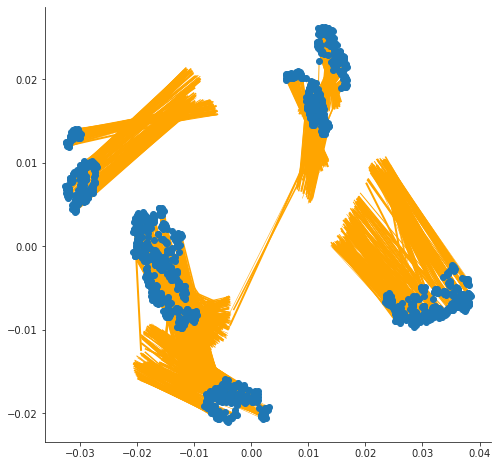

In [193]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

x = merged_scaled_df["umap_ha_scaled_x"].values
y = merged_scaled_df["umap_ha_scaled_y"].values

pos_x = merged_scaled_df["umap_concat_scaled_x"].values
pos_y = merged_scaled_df["umap_concat_scaled_y"].values

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x,y, "o")
#ax.plot(pos_x, pos_y, "o")
line_segments = LineCollection(line_segments, linewidths=(0.5, 1, 1.5, 2), color="orange", linestyle='solid')
ax.add_collection(line_segments)
#ax.quiver(x, y, pos_x, pos_y, zorder=5, angles='xy', scale_units='xy', scale=1)
#ax.set_xlim(-.01,.01)
#ax.set_ylim(-0.02, -.01)
plt.show()

In [ ]:
scatterplot_with_tooltip_interactive(merged_umap_df_ha,'umap_x','umap_y','umap_x','umap_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

In [ ]:
scatterplot_with_tooltip_interactive(merged_umap_df_concatenated,'umap_x','umap_y','umap_x','umap_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

In [ ]:
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df_ha,
    ['umap_x','umap_y'],
    ['umap_x','umap_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap

In [ ]:
list_of_chart_concatenated = linking_tree_with_plots_brush(
    merged_umap_df_concatenated,
    ['umap_x','umap_y'],
    ['umap_x','umap_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_umap_concatenated = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]
chart_umap_concatenated

In [ ]:
chart_umap & chart_umap_concatenated

# Linking all plots together clickable with Tree

In [ ]:
#merged_df = node_df.merge(
#    PrincipalDf_concatenated.merge)
merged_df = node_df[["strain", "date", "y", "clade_membership"]].merge(
    principalDf_concatenated,
    on="strain"
).merge(
    MDS_df_concatenated,
    on="strain"
).merge(
    TSNE_df_concatenated,
    on="strain"
).merge(
    UMAP_df_concatenated,
    on="strain"
)

In [ ]:
merged_df

In [ ]:
data = linking_tree_with_plots_brush(
    node_df.merge(merged_df[["strain"]], on="strain"),
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain'],
    domain,
    range_
)

In [ ]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
#fullChart.save("../docs/FullLinkedChartBrushableFluHA.html")
#fullChart.save("../docs/FullLinkedChartBrushableFluHA.png")
#save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

In [ ]:
filtered_merged_df = merged_df[merged_df["pca1"] < 10].copy()

In [ ]:
filtered_merged_df.shape

In [ ]:
merged_df.shape

In [ ]:
data = linking_tree_with_plots_brush(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca3', 'pca4', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA3 (Expected Variance : {}%'.format(round(explained_variance_PCA_concatenated[2]*100,2)) + ")",
    'PCA4 (Expected Variance : {}%'.format(round(explained_variance_PCA_concatenated[3]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain', 'clade_membership'],
    domain,
    range_
)

In [ ]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
#fullChart.save("../docs/FullLinkedChartBrushableFluHA.html")
#fullChart.save("../docs/FullLinkedChartBrushableFluHA.png")
#save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

# Final Chart

In [ ]:
merged_df.columns = ['strain', 'date', 'y', 'clade_membership', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca_label',
       'mds1', 'mds2', 'mds_label', 'tsne_x', 'tsne_y', 't-sne_label', 'umap_x',
       'umap_y', 'umap_label']

In [ ]:
node_df.columns = ['strain', 'date_ha', 'pca1_ha', 'pca2_ha', 'pca3_ha', 'pca4_ha', 'mds1_ha', 'mds2_ha',
       'tsne_x_ha', 'tsne_y_ha', 'umap_x_ha', 'umap_y_ha',
       'clade_membership_ha', 'pca_label_ha', 'mds_label_ha', 'umap_label_ha',
       't-sne_label_ha', 'y', 'clade_membership_color']

In [ ]:
node_df

In [ ]:
total_df = merged_df.merge(node_df, on="strain")

In [ ]:
data = linking_tree_with_plots_brush(
    total_df,
    ['mds1', 'mds2', 'mds1_ha', 'mds2_ha','tsne_x','tsne_y', 'tsne_x_ha', 'tsne_y_ha', 'pca1', 'pca2','pca1_ha', 'pca2_ha', 'umap_x','umap_y', 'umap_x_ha', 'umap_y_ha'],
    ['MDS1', 'MDS2', 'MDS1', 'MDS2', 'TSNE1', 'TSNE2', 'TSNE1', 'TSNE2', 
    'PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA_concatenated[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA_concatenated[1]*100,2)) + ")",
    'PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[1]*100,2)) + ")",'UMAP1','UMAP2','UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain', 'clade_membership'],
    domain,
    range_
)

In [ ]:
HA = data[2]|data[4]|data[6]|data[8]
CONCAT = data[1]|data[3]|data[5]|data[7]
embeddings = alt.vconcat(HA, CONCAT)
embeddings
#embeddings.save("../docs/HaNaAnalysisFinalChart.html")
#fullChart.save("../docs/FullLinkedChartBrushableFluHA.png")
save(embeddings, "../docs/HaNaAnalysisFinalChart.png", scale_factor=2.0)

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [49]:
Genetic_KDE_df_ha = pd.read_csv("results/KDEDensity_genetic_ha.csv",index_col=0)
Genetic_KDE_df_concatenated = pd.read_csv("results/KDEDensity_genetic_concatenated.csv",index_col=0)
Genetic_KDE_metadata_df_ha = pd.read_csv("results/KDEDensity_genetic_metadata_ha.csv", index_col=0)
Genetic_KDE_metadata_df_concatenated = pd.read_csv("results/KDEDensity_genetic_metadata_concatenated.csv", index_col=0)

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [50]:
MDS_KDE_df_ha = pd.read_csv("results/KDEDensity_mds_ha.csv",index_col=0)
MDS_KDE_df_concatenated = pd.read_csv("results/KDEDensity_mds_concatenated.csv",index_col=0)
MDS_KDE_metadata_df_ha = pd.read_csv("results/KDEDensity_mds_metadata_ha.csv", index_col=0)
MDS_KDE_metadata_df_concatenated = pd.read_csv("results/KDEDensity_mds_metadata_concatenated.csv", index_col=0)

UMAP_KDE_df_ha = pd.read_csv("results/KDEDensity_umap_ha.csv",index_col=0)
UMAP_KDE_df_concatenated = pd.read_csv("results/KDEDensity_umap_concatenated.csv",index_col=0)
UMAP_KDE_metadata_df_ha = pd.read_csv("results/KDEDensity_umap_metadata_ha.csv", index_col=0)
UMAP_KDE_metadata_df_concatenated = pd.read_csv("results/KDEDensity_umap_metadata_concatenated.csv", index_col=0)

In [61]:
MDS_KDE_metadata_df_concatenated

,accuracy,median_within,median_between,threshold,embedding,TN,FN,TP,FP
MCC,,,,,,,,,
0.621,0.886,-1.356,-0.025,-0.868,mds,1050409,17486,144157,136851


In [54]:
import matplotlib.gridspec as gridspec

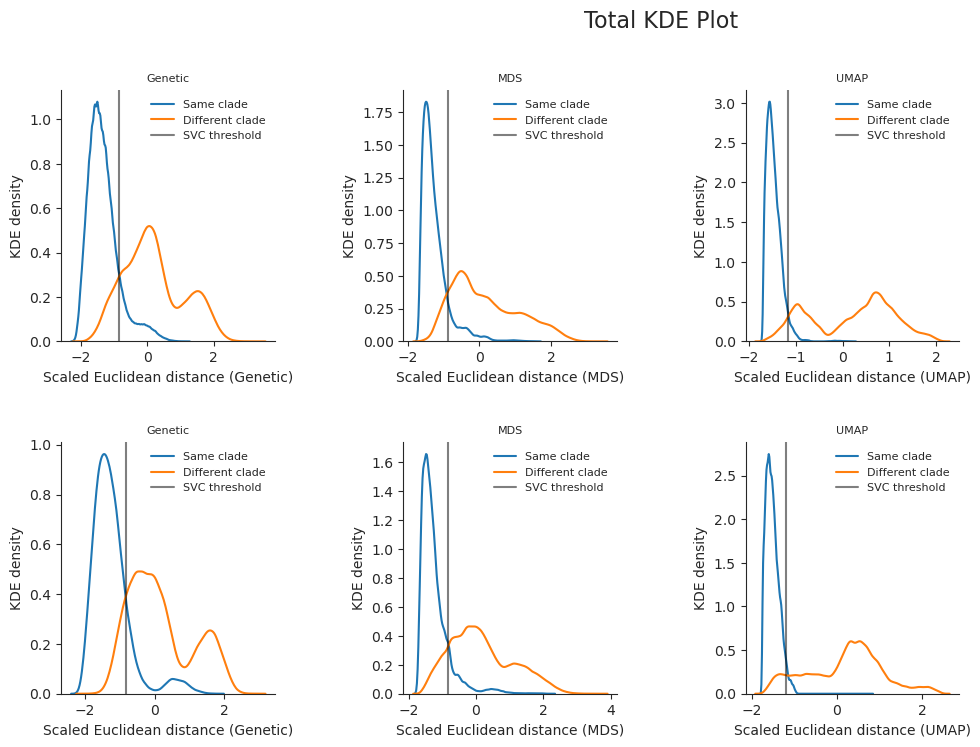

In [58]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#Genetic
ax4 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=Genetic_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('Genetic')
ax4.set_xlabel("Scaled Euclidean distance (Genetic)")
ax4.set_ylabel("KDE density")

#MDS
ax2 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=MDS_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.axvline(x=MDS_KDE_metadata_df_concatenated["MCC"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('MDS')
ax2.set_xlabel("Scaled Euclidean distance (MDS)")
ax2.set_ylabel("KDE density")

#MDS
ax5 = sns.kdeplot(MDS_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(MDS_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=MDS_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.axvline(x=MDS_KDE_metadata_df_ha["MCC"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('MDS')
ax5.set_xlabel("Scaled Euclidean distance (MDS)")
ax5.set_ylabel("KDE density")

#UMAP
ax3 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=UMAP_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.axvline(x=UMAP_KDE_metadata_df_concatenated["MCC"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('UMAP')
ax3.set_xlabel("Scaled Euclidean distance (UMAP)")
ax3.set_ylabel("KDE density")

#UMAP
ax6 = sns.kdeplot(UMAP_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax6)
ax6 = sns.kdeplot(UMAP_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax6)
ax6.axvline(x=UMAP_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax6.axvline(x=UMAP_KDE_metadata_df_ha["MCC"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax6.legend(frameon=False)
ax6.set_title('UMAP')
ax6.set_xlabel("Scaled Euclidean distance (UMAP)")
ax6.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FinalKDEPlotHACONCAT.png", dpi=600, bbox_inches='tight')

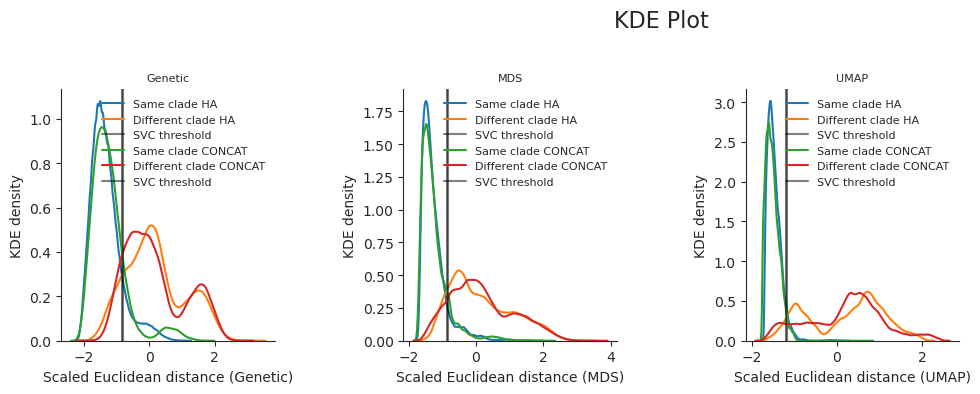

In [57]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade HA", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade HA", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

#Genetic
ax1 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade CONCAT", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade CONCAT", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#MDS
ax2 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade HA", ax=ax2)
ax2 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade HA", ax=ax2)
ax2.axvline(x=MDS_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

#MDS
ax2 = sns.kdeplot(MDS_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade CONCAT", ax=ax2)
ax2 = sns.kdeplot(MDS_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade CONCAT", ax=ax2)
ax2.axvline(x=MDS_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('MDS')
ax2.set_xlabel("Scaled Euclidean distance (MDS)")
ax2.set_ylabel("KDE density")

#UMAP
ax3 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade HA", ax=ax3)
ax3 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade HA", ax=ax3)
ax3.axvline(x=UMAP_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

#UMAP
ax3 = sns.kdeplot(UMAP_KDE_df_ha.query("clade_status == 1")["scaled_distance"], label="Same clade CONCAT", ax=ax3)
ax3 = sns.kdeplot(UMAP_KDE_df_ha.query("clade_status == 0")["scaled_distance"], label="Different clade CONCAT", ax=ax3)
ax3.axvline(x=UMAP_KDE_metadata_df_ha["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('UMAP')
ax3.set_xlabel("Scaled Euclidean distance (UMAP)")
ax3.set_ylabel("KDE density")


fig.suptitle('KDE Plot', fontsize=16)
sns.despine()
#plt.savefig("../docs/FinalHAKDEPlot.png", dpi=600, bbox_inches='tight')

In [ ]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df_concatenated.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df_concatenated["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FinalCONCATKDEPlot.png", dpi=600, bbox_inches='tight')

# Supplemental Figures

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.MDS_Supplement)
save(chart, snakemake.output.MDS_Supplement_PNG)

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.PCA_Supplement)
save(chart, snakemake.output.PCA_Supplement_PNG)